In [1]:
#import libraries we need
import pandas as pd
import numpy as np
from numpy.random import randn,rand
import seaborn as sns

In [2]:
#Read in our market data
brent = pd.read_csv("/home/volatily/market_data/Market Data UK Brent Oil.csv")

In [3]:
#Make sure the oldest date is first
brent = brent[::-1].reset_index().drop(columns=["index"])

In [38]:
brent

Time    Open    High     Low   Close  Target
0     2024.07.10 10:49:00  84.152  84.152  84.124  84.132  84.027
1     2024.07.10 10:50:00  84.132  84.149  84.127  84.142  84.012
2     2024.07.10 10:51:00  84.149  84.149  84.104  84.112  84.019
3     2024.07.10 10:52:00  84.107  84.107  84.072  84.095  84.037
4     2024.07.10 10:53:00  84.089  84.107  84.089  84.107  84.044
...                   ...     ...     ...     ...     ...     ...
9976  2024.07.22 09:37:00  81.641  81.641  81.621  81.627  81.623
9977  2024.07.22 09:38:00  81.626  81.641  81.601  81.606  81.639
9978  2024.07.22 09:39:00  81.605  81.621  81.594  81.601  81.629
9979  2024.07.22 09:40:00  81.605  81.627  81.596  81.617  81.608
9980  2024.07.22 09:41:00  81.616  81.616  81.587  81.591  81.608

[9981 rows x 6 columns]

In [4]:
#Preparing to label the data
look_ahead = 20

#Defining the target
brent["Target"] = brent["Close"].shift(-look_ahead)

#Drop missing values
brent.dropna(inplace=True)

In [5]:
#In this article we will cover some techniques for hyper-parameter tuning 
from scipy.optimize import minimize
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
import time

In [6]:
#Define the time series split parameters
splits = 5
gap = look_ahead

#Create the time series split object
tscv = TimeSeriesSplit(n_splits=splits,gap=gap)

#Create a dataframe to store our accuracy 
current_error_rate = pd.DataFrame(index = np.arange(0,splits),columns=["Current Error"])

In [7]:
#Define the predictors and the target
predictors = ["Open","High","Low","Close"]
target = "Target"

In [8]:
#Define the objective function
def objective(x):
    #The parameter x represents a new value for our neural network's settings
    #In order to find optimal settings, we will perform 10 fold cross validation using the new setting
    #And return the average RMSE from all 10 tests
    #We will first turn the model's Alpha parameter, which controls the amount of L2 regularization
    model = MLPRegressor(hidden_layer_sizes=(5,2),alpha=x[0],early_stopping=True,shuffle=False,learning_rate_init=x[1],tol=x[2])
    #Now we will cross validate the model
    for i,(train,test) in enumerate(tscv.split(brent)):
        #The data
        X_train = brent.loc[train[0]:train[-1],predictors]
        y_train = brent.loc[train[0]:train[-1],target]
        X_test  = brent.loc[test[0]:test[-1],predictors]
        y_test  = brent.loc[test[0]:test[-1],target]
        #Train the model
        model.fit(X_train,y_train)
        #Measure the RMSE
        current_error_rate.iloc[i,0] = root_mean_squared_error(y_test,model.predict(X_test))
    #Return the Mean CV RMSE
    return(current_error_rate.iloc[:,0].mean())

In [65]:
#Let us measure how much time this takes.
start = time.time()

#Create a dataframe to measure the error rates
starting_point_error = pd.DataFrame(index=np.arange(0,21),columns=["Average CV RMSE"])
starting_point_error["Iteration"] = np.arange(0,21)

#Let us first find a good starting point for our optimization algorithm
for i in np.arange(0,21):
    #Set a new starting point
    new_starting_point = (10.0 ** -i)
    #Store error rates
    starting_point_error.iloc[i,0] = objective([new_starting_point,new_starting_point,new_starting_point]) 

#Record the time stamp at the end
stop = time.time()

#Report the amount of time taken
print(f"Completed in {stop - start} seconds")

Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

Completed in 312.29402351379395 seconds


Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [66]:
starting_point_error

Average CV RMSE  Iteration
0          0.91546          0
1         0.267167          1
2        14.846035          2
3        15.763264          3
4        56.820397          4
5        75.202923          5
6        72.562681          6
7         64.33746          7
8        88.980977          8
9        83.791834          9
10       82.871215         10
11       88.031151         11
12       65.532539         12
13       78.177191         13
14       85.063947         14
15       88.631589         15
16       74.369735         16
17       86.133656         17
18       90.482654         18
19      102.803612         19
20       74.636781         20

<Axes: xlabel='Iteration', ylabel='Average CV RMSE'>

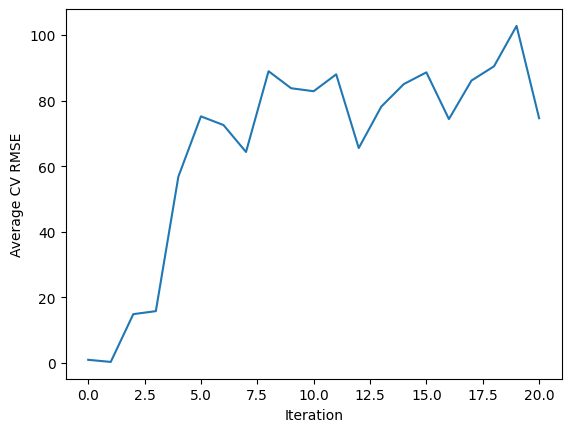

In [71]:
sns.lineplot(data=starting_point_error,x="Iteration",y="Average CV RMSE")

In [11]:
pt = abs(((10 ** -1) + rand(3) * ((10 ** 0) - (10 ** -1))))
pt

array([0.75747551, 0.34066536, 0.26214705])

In [12]:
start = time.time()
result = minimize(objective,pt,method="nelder-mead")
stop = time.time()
print(f"Task completed in {stop - start} seconds")

Task completed in 1332.9911317825317 seconds


In [13]:
result

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.12022686955703668
             x: [ 7.575e-01  3.577e-01  2.621e-01]
           nit: 225
          nfev: 600
 final_simplex: (array([[ 7.575e-01,  3.577e-01,  2.621e-01],
                       [ 7.575e-01,  3.577e-01,  2.621e-01],
                       [ 7.575e-01,  3.577e-01,  2.621e-01],
                       [ 7.575e-01,  3.577e-01,  2.621e-01]]), array([ 1.202e-01,  2.393e-01,  2.625e-01,  8.978e-01]))

In [14]:
#Let us compare our customised model and the defualt model
custom_model = MLPRegressor(hidden_layer_sizes=(5,2),alpha=result.x[0],early_stopping=True,shuffle=False,learning_rate_init=result.x[1],tol=result.x[2])

In [15]:
#Default model
default_model = MLPRegressor(hidden_layer_sizes=(5,2))

In [17]:
#Define the time series split parameters
splits = 10
gap = look_ahead

#Create the time series split object
tscv = TimeSeriesSplit(n_splits=splits,gap=gap)

#Create a dataframe to store our accuracy 
model_error_rate = pd.DataFrame(index = np.arange(0,splits),columns=["Default Model","Custom Model"])

In [20]:
#Now we will cross validate the model
for i,(train,test) in enumerate(tscv.split(brent)):
    #The data
    X_train = brent.loc[train[0]:train[-1],predictors]
    y_train = brent.loc[train[0]:train[-1],target]
    X_test  = brent.loc[test[0]:test[-1],predictors]
    y_test  = brent.loc[test[0]:test[-1],target]
    #Our model
    model = MLPRegressor(hidden_layer_sizes=(5,2),alpha=result.x[0],early_stopping=True,shuffle=False,learning_rate_init=result.x[1],tol=result.x[2])
    #Train the model
    model.fit(X_train,y_train)
    #Measure the RMSE
    model_error_rate.iloc[i,1] = root_mean_squared_error(y_test,model.predict(X_test))

In [21]:
model_error_rate

Default Model Custom Model
0      0.153904     0.550214
1      0.113818     0.501043
2     82.188345      0.52897
3      0.114108     0.117466
4      0.114718     0.112892
5     77.508403     0.258558
6      0.109191     0.304262
7      0.142143     0.363774
8      0.163161     0.153202
9      0.120068      2.20102

<Axes: >

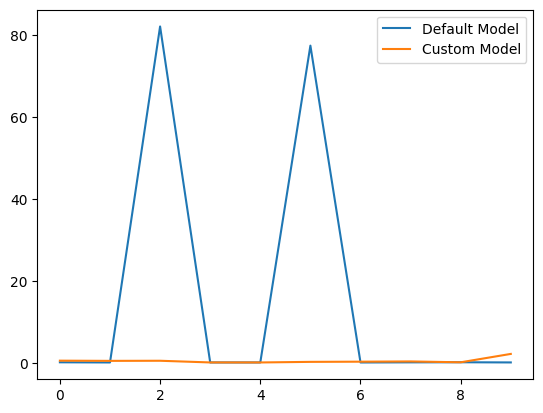

In [27]:
model_error_rate["Default Model"].plot(legend=True)
model_error_rate["Custom Model"].plot(legend=True)

In [30]:
#Now we will prepare to export our neural network into ONNX format
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn
import onnxruntime as ort
import netron

In [33]:
#Define the input types
initial_type = [("float_input",FloatTensorType([1,4]))]

In [36]:
#Fit our custom model
custom_model.fit(brent.loc[:,["Open","High","Low","Close"]],brent.loc[:,"Target"])

MLPRegressor(alpha=0.7574779735617514, early_stopping=True,
             hidden_layer_sizes=(5, 2), learning_rate_init=0.3576988271862944,
             shuffle=False, tol=0.26214587405791967)

In [37]:
#Create the onnx represantation
onnx = convert_sklearn(custom_model,initial_types=initial_type,target_opset=12)

In [39]:
#The name of our ONNX file
onnx_filename = "Brent_M1.onnx"

In [41]:
#Write out the ONNX file
with open(onnx_filename,"wb") as f:
    f.write(onnx.SerializeToString())

In [42]:
#Now let us inspect our ONNX model
onnx_session = ort.InferenceSession(onnx_filename)
input_name   = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

In [43]:
for i, input_tensor in enumerate(onnx_session.get_inputs()):
    print(f"{i + 1}. Name: {input_tensor.name}, Data Type: {input_tensor.type}, Shape: {input_tensor.shape}")

1. Name: float_input, Data Type: tensor(float), Shape: [1, 4]


In [44]:
for i, output_tensor in enumerate(onnx_session.get_outputs()):
    print(f"{i + 1}. Name: {output_tensor.name}, Data Type: {output_tensor.type}, Shape: {output_tensor.shape}")

1. Name: variable, Data Type: tensor(float), Shape: [1, 1]


In [45]:
#We can also inspect our model visually using netron.
netron.start(onnx_filename)

Serving 'Brent_M1.onnx' at http://localhost:8080


('localhost', 8080)